# Chapter 8. 어텐션

## 어텐션의 구조
* 어텐션 : seq2seq를 필요한 정보에만 주목하게 함.
    * 이를 통해 seq2seq가 갖고 있는 문제를 해결 가능

### seq2seq의 문제점
* 이전의 seq2seq는 Encoder가 고정 길이의 벡터를 출력  
    * 아무리 긴 문장이 있더라도 고정된 길이의 벡터로 반환해야 하기 때문에 한계가 있다.

### Encoder 개선
* 시각 별 LSTM 계층의 은닉 상태 벡터를 모두 사용 : 이렇게 되면 입력된 단어 길이와 같은 수의 벡터를 얻을 수 있다. 
* 여러 딥러닝 프레임워크에서 RNN 계층을 초기화할 때 모든 시각의 은닉 상태 벡터 변환과 마지막 은닉 상태 벡터만 반환 둘 중 하나로 설정할 수 있다.
* 각 시각의 은닉 상태에는 해당 시각에 입력된 단어의 정보가 많이 담겨 있을 것이다.
* 문장에서 단어의 정보는 주변 정보를 균형 있게 담아야 하기 때문에 양방향 RNN이나 양방향 LSTM을 사용하면 효과적

### Decoder 개선 1
* **얼라인먼트(alignment)**: 단어(혹은 문구)의 대응 관계를 나타내는 정보, 이전까지는 사람의 수작업으로 만들어졌다. 
    * 어텐션 : 얼라인먼트 자동으로 수행

* 어텐션 : 필요한 정보에만 주목해서 그 정보로부터 시계열 변환을 수행

<img src='./images/fig_8-6.png' width=700>

* 입력 : Encoder로부터 온 hs와 시각별 LSTM 계층의 은닉 상태이다. 
    * 필요한 정보만 골라 Affine 계층으로 출력한다.
    * Encoder의 마지막 은닉 상태 벡터 : Decoder의 첫번째 LSTM 계층로 전달된다.

* Decoder에서 출력을 할 때 필요한 정보를 hs에서 선택하는 과정이다. 
    * 하지만 선택하는 작업은 미분할 수 없다는 문제 발생
    * 이 문제를 **전체를 선택한 후 각 단어의 가중치를 별도로 계산하는 문제로 치환**하면 미분 가능

<img src="./images/fig_8-8.png" width=600>

* 각 단어의 중요도를 나타내는 가중치 a(확률분포와 유사)를 구한 후 단어 벡터 hs와 가중합을 계산해서 맥락 벡터 c를 구한다. 
    * '나'에 대응하는 가중치가 0.8이었으니 맥락 벡터에는 '나' 벡터의 성분이 많이 포함된 걸로 해석 가능
    * 맥락 벡터 c : 현 시각의 변환을 수행하는데 필요한 정보가 담겨야 한다.
    * 결국 이렇게 학습하도록하는 것이 궁극적인 목표이다.

In [8]:
import numpy as np
T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis=1)
print(ar.shape)

t = hs * ar
print(t.shape)

c = np.sum(t, axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


In [9]:
# 미니배치 처리 : 가중합 구현
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
# ar = a.reshape(N, T, 1) # 브로드캐스트를 사용하는 경우

t = hs * ar
print(t.shape)

c = np.sum(t, axis=1)
print(c.shape)

(10, 5, 4)
(10, 4)


In [10]:
class WeightSum:
    
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        
        return c
    
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)
        
        return dhs

### Decoder 개선 2
* 가중치 a도 데이터로부터 자동으로 학습할 수 있도록 해야 한다.
* Decoder의 LSTM 계층의 은닉 상태 벡터(h)와 Encoder의 마지막 시각의 hs 사이의 유사도는 벡터의 내적으로 구할 수 있다. 
    * 내적은 두 벡터가 얼마나 같은 방향을 향하고 있는지를 나타낸다. 내적을 하면 정규화하기 전의 점수 s를 구할 수 있다. 
* s는 일반적으로 소프트맥스 함수를 거쳐 정규화해 가중치 a를 구한다.

In [11]:
from common.layers import Softmax
import numpy as np
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H)

t = hs * hr
print(t.shape)

s = np.sum(t, axis=2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


In [12]:
from common.np import *
from common.layers import Softmax

class AttentionWeight:
    
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
        
    
    def forward(self, hs, h):
        N, T, H = hs.shape
        
        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)
        
        self.cache = (hs, hr)
        return a
    
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)
        
        return dhs, dh

### Decoder 개선 3

<img src="./images/fig_8-16.png" width=600>

현재까지 Weight Sum, Attention Weight 게층이라고 하고, 이 둘을 합쳐서 Attention 계층이라고 한다.

In [13]:
class Attention:
    
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
        
        
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        
        return out
    
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        
        return dhs, dh

<img src="./images/fig_8-18.png" width=700>

* Affine 계층에 맥락 벡터와 은닉 상태 벡터가 입력
* 다수의 Attention 계층을 모아 Time Attention 계층 구현 가능

<img src="./images/fig_8-20.png" width=700>

In [14]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

## 어텐션을 갖춘 seq2seq 구현
### Encoder 구현

In [15]:
import sys
sys.path.append('..')
from common.time_layers import *
from seq2seq import Encoder, Seq2seq
from attention_layer import TimeAttention


class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### Decoder 구현

In [17]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

### seq2seq 구현

In [18]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 어텐션 평가
### 날짜 형식 변환 문제  

* 번역용 데이터셋 : WMT
    * 너무 커서 날짜 형식 변경 문제로 대체
    
* 사람이 쓴 날짜 데이터(형식에 맞추지 않음)를 표준 형식(YYYY-MM-DD)으로 변환

    * 사람이 쓴 날짜 데이터의 형식은 매우 많으므로 수작업으로 해당 패턴을 찾아서 변환 규칙을 만드는 것은 매우 번거롭다.  
    * 입력과 출력의 대응 관계를 쉽게 알 수 있다.

<img src="./images/fig_8-23.png" width=500>

* 입력과 출력의 구분 문자는 \_, 출력의 끝은 출력의 길이가 모두 동일해서 따로 두지 않았다.

### 어텐션을 갖춘 seq2seq의 학습

In [27]:
import numpy as np
from dataset import sequence
from common.optimizer import SGD
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq

In [20]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = SGD()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))
    
model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 6[s] | 손실 4.06
| 에폭 1 |  반복 41 / 351 | 시간 12[s] | 손실 4.03
| 에폭 1 |  반복 61 / 351 | 시간 19[s] | 손실 4.00
| 에폭 1 |  반복 81 / 351 | 시간 25[s] | 손실 3.97
| 에폭 1 |  반복 101 / 351 | 시간 31[s] | 손실 3.93
| 에폭 1 |  반복 121 / 351 | 시간 37[s] | 손실 3.90
| 에폭 1 |  반복 141 / 351 | 시간 43[s] | 손실 3.87
| 에폭 1 |  반복 161 / 351 | 시간 49[s] | 손실 3.84
| 에폭 1 |  반복 181 / 351 | 시간 55[s] | 손실 3.80
| 에폭 1 |  반복 201 / 351 | 시간 61[s] | 손실 3.77
| 에폭 1 |  반복 221 / 351 | 시간 67[s] | 손실 3.73
| 에폭 1 |  반복 241 / 351 | 시간 73[s] | 손실 3.69
| 에폭 1 |  반복 261 / 351 | 시간 79[s] | 손실 3.65
| 에폭 1 |  반복 281 / 351 | 시간 85[s] | 손실 3.61
| 에폭 1 |  반복 301 / 351 | 시간 91[s] | 손실 3.56
| 에폭 1 |  반복 321 / 351 | 시간 97[s] | 손실 3.51
| 에폭 1 |  반복 341 / 351 | 시간 103[s] | 손실 3.46
Q 10/15/94                     
T 1994-10-15
☒ ----------
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ ----------
---
Q Mar 25, 2003                 
T 2003-03-25
☒ ----------
---
Q Tuesday, November 22, 2016 

| 에폭 6 |  반복 301 / 351 | 시간 92[s] | 손실 1.93
| 에폭 6 |  반복 321 / 351 | 시간 98[s] | 손실 1.93
| 에폭 6 |  반복 341 / 351 | 시간 104[s] | 손실 1.92
Q 10/15/94                     
T 1994-10-15
☒ 19-0-0-0-0
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 19-0-0-0-0
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 19-0-0-0-0
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☒ 19-0-0-0-0
---
Q Saturday, July 18, 1970      
T 1970-07-18
☒ 19-0-0-0-0
---
Q october 6, 1992              
T 1992-10-06
☒ 19-0-0-0-0
---
Q 8/23/08                      
T 2008-08-23
☒ 19-0-0-0-0
---
Q 8/30/07                      
T 2007-08-30
☒ 19-0-0-0-0
---
Q 10/28/13                     
T 2013-10-28
☒ 19-0-0-0-0
---
Q sunday, november 6, 2016     
T 2016-11-06
☒ 19-0-0-0-0
---
val acc 0.000%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 1.93
| 에폭 7 |  반복 21 / 351 | 시간 6[s] | 손실 1.91
| 에폭 7 |  반복 41 / 351 | 시간 11[s] | 손실 1.91
| 에폭 7 |  반복 61 / 351 | 시간 17[s] | 손실 1.91
| 에폭 7 |  반복 81 / 351 | 시간 23[s] | 손실 1.90
| 에폭 7 |  반복 101 / 3

In [28]:
model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list1 = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
        
    acc1 = float(correct_num) / len(x_test)
    acc_list1.append(acc1)
    print('val acc %.3f%%' % (acc1 * 100))
    
model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 6[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 12[s] | 손실 1.87
| 에폭 1 |  반복 61 / 351 | 시간 18[s] | 손실 1.66
| 에폭 1 |  반복 81 / 351 | 시간 24[s] | 손실 1.31
| 에폭 1 |  반복 101 / 351 | 시간 30[s] | 손실 1.17
| 에폭 1 |  반복 121 / 351 | 시간 36[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 42[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 48[s] | 손실 1.05
| 에폭 1 |  반복 181 / 351 | 시간 55[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 61[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 67[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 73[s] | 손실 1.01
| 에폭 1 |  반복 261 / 351 | 시간 79[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 85[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 91[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 97[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 103[s] | 손실 0.99
Q 10/15/94                     
T 1994-10-15
☒ 1992-03-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1992-03-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1992-03-11
---
Q Tuesday, November 22, 2016 

| 에폭 6 |  반복 301 / 351 | 시간 91[s] | 손실 0.00
| 에폭 6 |  반복 321 / 351 | 시간 97[s] | 손실 0.00
| 에폭 6 |  반복 341 / 351 | 시간 102[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
val acc 0.000%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 6[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 12[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 18[s] | 손실 0.00
| 에폭 7 |  반복 81 / 351 | 시간 24[s] | 손실 0.00
| 에폭 7 |  반복 101 / 3

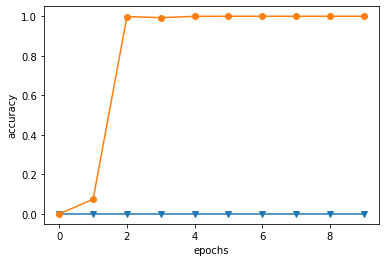

In [30]:
import matplotlib.pyplot as plt

x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='v')
plt.plot(x, acc_list1, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

<img src="./images/fig_8-26.png" width=600>

* 기본 seq2seq : 낮은 정확도
* peeky와 어텐션 : 비슷한 정확도, 어텐션이 학습 속도우세
* 현실의 시계열은 훨씬 복잡 : 어텐션 추천
* 어텐션 쓰더라도 SGD쓰면 최악의 결과가 나온다.

### 어텐션 시각화
* Time Attention 계층의 인스턴스 변수 attention_weight에 각 시각의 어텐션 가중치를 이용
    * 입력 문장과 출력 문장의 단어 대응 관계를 2차원 맵으로 그릴 수 있다.

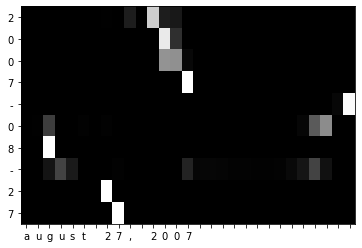

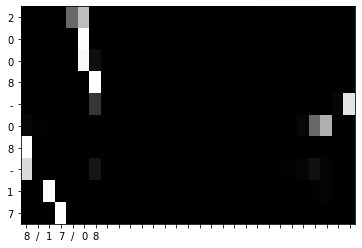

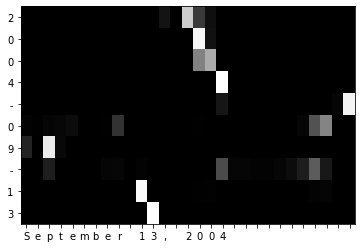

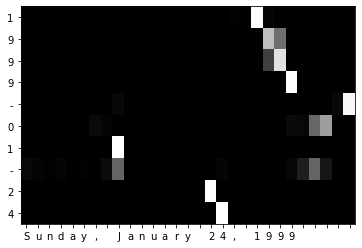

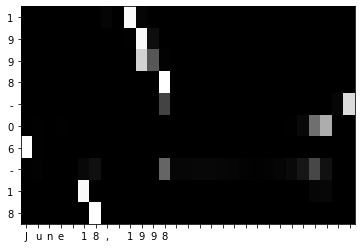

In [29]:
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt
from attention_seq2seq import AttentionSeq2seq


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(2019)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)


## 어텐션에 관한 남은 이야기
### 양방향 RNN
* 양방향 LSTM에 역방향도 처리하는 LSTM 계층을 추가
    * 각 시각마다 두 LSTM 계층의 은닉 상태를 연결시킨 벡터를 최종 은닉 상태로 처리
    * 서로 합하거나 평균하는 방법도 있다.

* 이점 : 은닉 상태 벡터에 좌, 우 양쪽 방향의 균형 잡힌 정보를 인코딩 가능
* 구현 : 단순히 입력 단어를 반대로 나열해서 입력하는 LSTM 계층을 하나 더 만든 후, 정방향으로 처리하는 계층의 출력과 연결

In [ ]:
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

### 어텐션 계층 사용 방법
<img src="./images/fig_8-32.png" width=700>

* Attention 계층의 출력이 다음 시각의 LSTM 계층에 입력되도록 연결
* 직접 구현한 경우는 Affine 계층에서 맥락 벡터를 이용한 반면 이 경우에는 LSTM 계층에서 맥락 벡터를 이용

* 구현 측면
    * LSTM과 Affine 계층 사이에 Attention 계층을 삽입하는 것이 쉽다.
    * 최종 정확도 : 큰 차이가 없다.

### seq2seq 심층화와 skip 연결
<img src="./images/fig_8-33.png" width=700>

* 일반적으로 Encoder과 Decoder의 LSTM 계층을 동일한 수로 구성
* 여러 방식으로 심층화 가능

<img src="./images/fig_8-34.png" width=300>

* **skip 연결** : 층을 깊게 할 때 기울기가 잘 흐를 수 있도록 하는 방법
    * 계층을 건너뛰는 연결
    * LSTM의 출력과 LSTM을 통과하지 않은 출력의 잔차의 원소별 덧셈을 해준다.
    * 덧셈은 역전파 시 기울기를 그대로 흘려보낼 수 있게 해준다.

* 층을 깊게 하면 여전히 오버피팅 문제가 발생 가능
    * 일반화 성능을 유지해주기 위해서 드롭아웃과 가중치 공유 등의 기술을 사용한다.

## 어텐션 응용
### 구글 신경망 기계 번역(GNMT)
<img src="./images/fig_8-35.png" width=700>

### 트렌스포머
* 트랜스포머 : RNN 대신 어텐션을 사용
<img src="./images/fig_8-37.png" width=600>
<img src="./images/fig_8-38.png" width=600>

### 뉴럴튜닝머신(NMT)
<img src="./images/fig_8-41.png" width=700>